In [1]:
import torch
from model_triton import *

#dloss_dx = torch.randn((2, 512, 3072), device="cuda")
#Two shapes are being used: [8, 12, 512, 512], and 4096, 35374
aa = torch.randn((8, 512, 768), device="cuda")
#aa = torch.randn((4096, 35374), device="cuda")
#aa = aa.view(-1)
N = 100

from functools import partial
fn_naive = partial(t_dropout_fwd, train=True, p_gen_aux=42)
fn_jit = torch.compile(fn_naive)
# burn it
fn_jit(aa) 
#fn_jit(dloss_dx, aa) 

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        result = fn_jit(aa)
        #result = fn_jit(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

import time
t0 = time.time()
for _ in range(N):
    result = fn_jit(aa)
    #result = fn_jit(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'JIT total', total)

import time
t0 = time.time()
for _ in range(N):
    result = fn_naive(aa)
    #result = fn_naive(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'Naive total', total)

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/variables/functions.py:725: UserWarning: Graph break due to unsupported builtin None.Generator.__new__. This function is either a Python builtin (e.g. _warnings.warn) or a third-party C/C++ Python extension (perhaps created with pybind). If it is a Python builtin, please file an issue on GitHub so the PyTorch team can add support for it and see the next case for a workaround. If it is a third-party C/C++ Python extension, please either wrap it into a PyTorch-understood custom operator (see https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html for more details) or, if it is traceable, use torch.compiler.allow_in_graph.
  torch._dynamo.utils.warn_once(msg)


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  Torch-Compiled Region        64.79%      16.084ms       384.02%      95.333ms     190.667us       0.000us         0.00%      73.257ms     146.513us           500  
                                                triton_         0.00%       0.000us         0.00%       0.000us       0.000us      10.466ms        64.05%      10.466ms      52.330us           200  
         

In [2]:
# import triton
# print(triton.runtime.driver.active.get_current_target())
# device = "cuda" #triton.runtime.driver.active.get_active_torch_device()
# properties = triton.runtime.driver.active.utils.get_device_properties(device)
# See https://github.com/triton-lang/triton/issues/5628, and https://github.com/triton-lang/triton/issues/5388
# properties

In [20]:
import triton
import triton.language as tl

T_DROPOUT_RATE: triton.language.constexpr = 0.1

# Note that the kernel assumes that n_cols < BLOCK_SIZE
@triton.jit
def t_dropout_fwd_k(x_ptr,
                    train,
                    p_gen_aux,
                    output_ptr,
                    input_row_stride,
                    output_row_stride,
                    n_rows,
                    n_cols,
                    BLOCK_SIZE: tl.constexpr,
                    num_stages: tl.constexpr,
                    ):
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages):
        x_row_start_ptr = x_ptr + row_idx * input_row_stride
        offsets = tl.arange(0, BLOCK_SIZE)
        mask = offsets < n_cols
        x = tl.load(x_row_start_ptr + offsets, mask=mask, other=0.0)
        if train:
            random = tl.rand(p_gen_aux+row_idx, offsets) # TODO T: Is this enough as diff seed per row?
            x_mask = random>T_DROPOUT_RATE
            output = tl.where(x_mask, x, 0.0)  
        else:
            output = x * (1-T_DROPOUT_RATE)
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        tl.store(output_row_start_ptr + offsets, output, mask=mask)
    
def t_dropout_fwd_t(x: torch.Tensor, train=True, p_gen_aux=None):
    x_2d = x.reshape((-1, x.shape[-1])) # TODO T: without this reshape, this func is 2times faster
    n_rows, n_cols = x_2d.shape
    BLOCK_SIZE = triton.next_power_of_2(n_cols) 
    output = torch.empty_like(x_2d)
    # TODO T: The below numbers were tuned for A10 by choosing num_wraps=8
    num_stages = 2
    num_programs = min(n_rows, 480) 
    t_dropout_fwd_k[(num_programs,)](x_2d, train, p_gen_aux, output, x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages)
    return output.reshape(x.shape)

fn_t = partial(t_dropout_fwd_t, train=True, p_gen_aux=42)

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        result = fn_t(aa)
        #result = fn_t(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

import time
t0 = time.time()
for _ in range(N):
    result = fn_t(aa)
    #result = fn_t(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)

-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
          t_dropout_fwd_k         0.00%       0.000us         0.00%       0.000us       0.000us       5.533ms       100.00%       5.533ms      55.327us           100  
            aten::reshape         6.53%     298.824us        13.82%     632.618us       3.163us       0.000us         0.00%       0.000us       0.000us           200  
               aten::view         7.29%     333.794us         7.29%     333.794us       1.669us       0.000us         0.00%       0.000us       0.000us        

In [13]:
res1 = fn_jit(aa)
#res1 = fn_jit(dloss_dx, aa)
res2 = fn_t(aa)
#res2 = fn_t(dloss_dx, aa)

assert torch.allclose(res1, res2), (res1[0], res2[0])
print(f'res1', res1.shape, res1[0])
print(f'res2', res2.shape, res2[0])

AssertionError: (tensor([[ 0.2607,  0.4285, -0.3629,  ..., -0.3505,  1.8142,  0.7115],
        [ 0.1257, -0.4082,  2.1643,  ...,  0.6425, -0.0112,  1.8678],
        [ 0.2768, -1.1929,  0.1470,  ..., -0.9205,  0.6240, -1.1486],
        ...,
        [-0.7191, -0.4280, -0.0000,  ..., -1.2365, -0.0000,  0.0329],
        [-0.0000, -0.2787, -1.5003,  ...,  0.6397, -1.0525,  0.6258],
        [ 1.2475,  0.0989,  0.5811,  ..., -0.5625, -0.5811,  0.1539]],
       device='cuda:0'), tensor([[ 0.2607,  0.0000, -0.3629,  ..., -0.3505,  1.8142,  0.7115],
        [ 0.1257, -0.4082,  2.1643,  ...,  0.6425, -0.0112,  1.8678],
        [ 0.2768, -1.1929,  0.1470,  ..., -0.9205,  0.6240, -1.1486],
        ...,
        [-0.7191, -0.4280, -1.3124,  ..., -1.2365, -0.0540,  0.0329],
        [-0.3999, -0.2787, -1.5003,  ...,  0.6397, -1.0525,  0.6258],
        [ 1.2475,  0.0989,  0.5811,  ..., -0.5625, -0.5811,  0.1539]],
       device='cuda:0'))

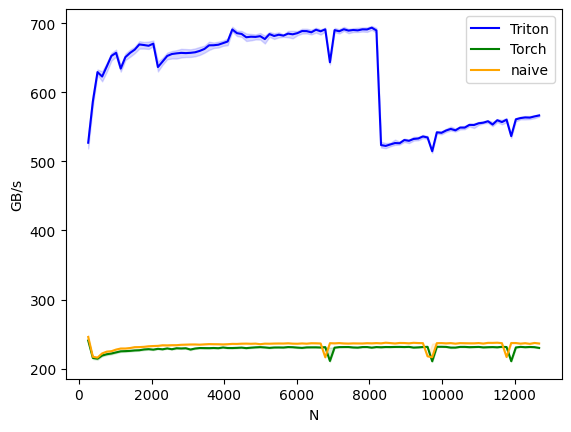

t_log_softmax_fwd:
          N      Triton       Torch       naive
0     256.0  527.099213  240.646269  245.760006
1     384.0  586.889570  215.500192  217.086495
2     512.0  629.397375  214.345053  215.874826
3     640.0  622.965770  218.915473  222.005411
4     768.0  637.647567  220.804481  224.566526
5     896.0  652.872870  221.869419  225.209632
6    1024.0  657.277041  223.481670  227.555555
7    1152.0  634.446744  225.037771  229.087515
8    1280.0  651.019879  225.312862  229.080110
9    1408.0  657.152251  225.656086  229.792067
10   1536.0  661.886981  226.333073  231.020424
11   1664.0  669.435312  226.587230  231.146647
12   1792.0  668.572275  227.725001  231.537009
13   1920.0  667.523749  228.171761  232.323928
14   2048.0  670.587921  227.473276  232.689396
15   2176.0  636.696033  228.613960  232.923521
16   2304.0  644.675079  227.936616  233.778831
17   2432.0  652.783233  229.231232  233.618008
18   2560.0  655.578522  228.030620  233.903989
19   2688.0  656.5062

In [21]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # Argument names to use as an x-axis for the plot.
        x_vals=[128 * i for i in range(2, 100)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'naive'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'naive'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='t_log_softmax_fwd',  # Name for the plot. Used also as a file name for saving the plot.
        args={'M':4096},  # Values for function arguments not in `x_names` and `y_name`.
        # TODO T: Use real M i.e. 
    ))
def benchmark(M, N, provider):
    #dloss_dx = torch.rand(size, device="cuda", dtype=torch.float32)    
    x = torch.rand(M, N, device="cuda", dtype=torch.float32)
    stream = getattr(torch, "cuda").Stream() # TODO XXX XXX: what is this stream about?
    getattr(torch, "cuda").set_stream(stream)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(dloss_dx, x), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(x), quantiles=quantiles)        
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(dloss_dx, x), quantiles=quantiles)
    if provider == 'naive':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(dloss_dx, x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [14]:
import torch
print(torch.cuda.get_device_properties("cuda"))
from triton.runtime import driver
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
SIZE_SMEM = properties["max_shared_mem"]
NUM_REGS = properties["max_num_regs"]
WARP_SIZE = properties["warpSize"] # Not 64 as A100
properties

_CudaDeviceProperties(name='NVIDIA A10G', major=8, minor=6, total_memory=22723MB, multi_processor_count=80, uuid=df82317b-d317-7368-eed6-8c8a4866f43b, L2_cache_size=6MB)


{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 80,
 'warpSize': 32,
 'sm_clock_rate': 1710000,
 'mem_clock_rate': 6251000,
 'mem_bus_width': 384}

In [19]:
num_stages = 4 if SIZE_SMEM > 200000 else 2
num_warps = 8
x_2d = aa.reshape((-1, aa.shape[-1])) # TODO T: without this reshape, this func is 2times faster
n_rows, n_cols = x_2d.shape
BLOCK_SIZE = triton.next_power_of_2(n_cols) 
output = torch.empty_like(x_2d)
print(f'num_stages', num_stages, 'num_warps', num_warps)

kernel = t_dropout_fwd_k.warmup(x_2d, True, 42, output, x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
kernel._init_handles()
n_regs = kernel.n_regs
size_smem = kernel.metadata.shared
print(f'n_regs', n_regs, 'size_smem', size_smem)

occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
size_smem = max(1, size_smem)
print(f'occupancy', occupancy, SIZE_SMEM // size_smem)
occupancy = min(occupancy, SIZE_SMEM // size_smem)
num_programs = NUM_SM * occupancy
print(f'num_programs', num_programs)

num_stages 2 num_warps 8
n_regs 39 size_smem 0
occupancy 6 101376
num_programs 480


In [ ]:
32
2080
4128
6176